# 🧠 Bidirectional GRU Model
## Efficient Recurrent Network for Time Series.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import json
import datetime
import warnings
import glob

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
tf.random.set_seed(42)
np.random.seed(42)

# ======================
# 1. Local Dataset Path
# ======================
FILE_PATH = "../data/features/btc_features_complete.csv"

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at: {FILE_PATH}")

print(f"✅ Dataset path configured: {FILE_PATH}")

# ======================
# 2. Configuration
# ======================
MODEL_NAME = "gru"
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']
MODEL_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_model.h5"
METADATA_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_metadata.json"
SCALER_SAVE_PATH = f"../models/{MODEL_NAME}/btc_{MODEL_NAME}_hourly_scaler.pkl"

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

c:\Users\15086\Desktop\ml-dl-dashbord\dl-ml-btc\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Downloading Kaggle dataset...
✅ Dataset downloaded to: C:\Users\15086\.cache\kagglehub\datasets\oussamataghlaoui\deeb-btc\versions\1
📁 CSV File: C:\Users\15086\.cache\kagglehub\datasets\oussamataghlaoui\deeb-btc\versions\1\btc_features_complete.csv


In [2]:

def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = df.select_dtypes(include=[np.number])
    
    # Lag Features
    target_lags = ['returns', 'RSI_14', 'MACD_hist', 'Close', 'Volume']
    existing = [f for f in target_lags if f in df.columns]
    for f in existing:
        for lag in range(1, 4):
            df[f'{f}_lag_{lag}'] = df[f].shift(lag)
            
    return df.ffill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f"Data loaded: {df.shape}")


Data loaded: (69858, 84)


In [3]:

# ======================
# 3. Feature Selection
# ======================
target_col = 'target_direction'
X = df.drop(columns=[c for c in df.columns if 'target' in c or 'future' in c])
y = df[target_col]

selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)
top_features = X.columns[selector.get_support()]
print(f"Selected Features: {list(top_features)}")


Selected Features: ['returns', 'log_returns', 'momentum_24h', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI_14', 'RSI_21', 'STOCH_K', 'STOCH_D', 'CCI_20', 'WILLR_14', 'MFI_14', 'close_to_sma20', 'close_to_sma50', 'returns_lag_1', 'RSI_14_lag_1', 'RSI_14_lag_2', 'MACD_hist_lag_1', 'MACD_hist_lag_2']


In [4]:

# ======================
# 4. Sequence Creation
# ======================
WINDOW_SIZE = 24

def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[top_features])
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW_SIZE)

split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

print(f"Train Shape: {X_train_seq.shape}")
print(f"Test Shape: {X_test_seq.shape}")

# Save scaler
joblib.dump(scaler, SCALER_SAVE_PATH)


Train Shape: (55867, 24, 20)
Test Shape: (13967, 24, 20)


['../models/gru/btc_gru_hourly_scaler.pkl']

In [5]:

# ======================
# 5. Bidirectional GRU Architecture
# ======================
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(WINDOW_SIZE, len(top_features))),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,121 (191.88 KB)

 Trainable params: 49,121 (191.88 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# ======================
# 6. Training
# ======================
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5),
        ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True)
    ]
)


Epoch 1/50
698/699 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.5082 - accuracy: 0.5076 - loss: 0.6968

699/699 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - AUC: 0.5106 - accuracy: 0.5092 - loss: 0.6949 - val_AUC: 0.5245 - val_accuracy: 0.5162 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5192 - accuracy: 0.5153 - loss: 0.6930

699/699 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - AUC: 0.5205 - accuracy: 0.5151 - loss: 0.6927 - val_AUC: 0.5357 - val_accuracy: 0.5269 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 3/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5263 - accuracy: 0.5221 - loss: 0.6922

699/699 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - AUC: 0.5277 - accuracy: 0.5224 - loss: 0.6920 - val_AUC: 0.5364 - val_accuracy: 0.5264 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 4/50
698/699 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.5282 - accuracy: 0.5203 - loss: 0.6920

699/699 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - AUC: 0.5299 - accuracy: 0.5224 - loss: 0.6918 - val_AUC: 0.5387 - val_accuracy: 0.5310 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 5/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - AUC: 0.5336 - accuracy: 0.5248 - loss: 0.6915 - val_AUC: 0.5367 - val_accuracy: 0.5267 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 6/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5330 - accuracy: 0.5261 - loss: 0.6915

699/699 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - AUC: 0.5342 - accuracy: 0.5263 - loss: 0.6913 - val_AUC: 0.5359 - val_accuracy: 0.5283 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 7/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - AUC: 0.5332 - accuracy: 0.5250 - loss: 0.6915

699/699 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - AUC: 0.5351 - accuracy: 0.5250 - loss: 0.6911 - val_AUC: 0.5392 - val_accuracy: 0.5302 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 8/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - AUC: 0.5366 - accuracy: 0.5262 - loss: 0.6909 - val_AUC: 0.5386 - val_accuracy: 0.5280 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 9/50
698/699 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.5354 - accuracy: 0.5251 - loss: 0.6912

699/699 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - AUC: 0.5372 - accuracy: 0.5263 - loss: 0.6909 - val_AUC: 0.5406 - val_accuracy: 0.5332 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 10/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - AUC: 0.5385 - accuracy: 0.5277 - loss: 0.6907 - val_AUC: 0.5369 - val_accuracy: 0.5265 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 11/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - AUC: 0.5399 - accuracy: 0.5286 - loss: 0.6905 - val_AUC: 0.5374 - val_accuracy: 0.5269 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 12/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - AUC: 0.5412 - accuracy: 0.5289 - loss: 0.6903 - val_AUC: 0.5348 - val_accuracy: 0.5246 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 13/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - AUC: 0.5437 - accuracy: 0.5293 - loss: 0.6901 - val_AUC: 0.5340 - val_accuracy: 0.5252 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 14/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - AUC: 0.5452 - accura

437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Test Accuracy: 0.5194
Test AUC: 0.5247
              precision    recall  f1-score   support

           0       0.51      0.57      0.54      6896
           1       0.53      0.47      0.50      7071

    accuracy                           0.52     13967
   macro avg       0.52      0.52      0.52     13967
weighted avg       0.52      0.52      0.52     13967



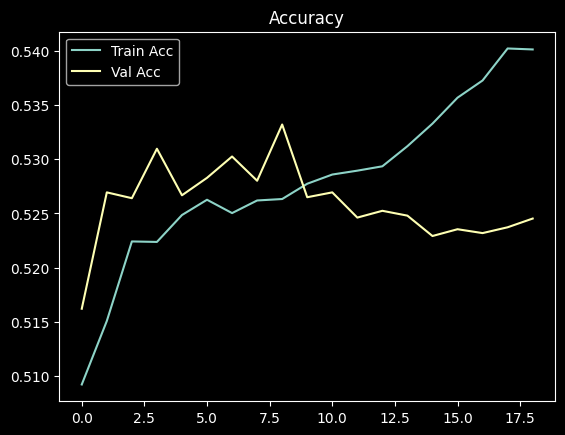

In [7]:

# ======================
# 7. Evaluation
# ======================
model = load_model(MODEL_SAVE_PATH)
y_pred_proba = model.predict(X_test_seq)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
acc = accuracy_score(y_test_seq, y_pred)
auc = roc_auc_score(y_test_seq, y_pred_proba)
prec = precision_score(y_test_seq, y_pred)
rec = recall_score(y_test_seq, y_pred)
f1 = f1_score(y_test_seq, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")
print(classification_report(y_test_seq, y_pred))

# History Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


--- Strategy Performance Comparison ---
         Metric   Strategy  Benchmark
   Total Return     70.6%     18.3%
Ann. Volatility      7.8%      7.8%
   Sharpe Ratio      3.01      0.97
   Max Drawdown     -4.8%     -4.5%


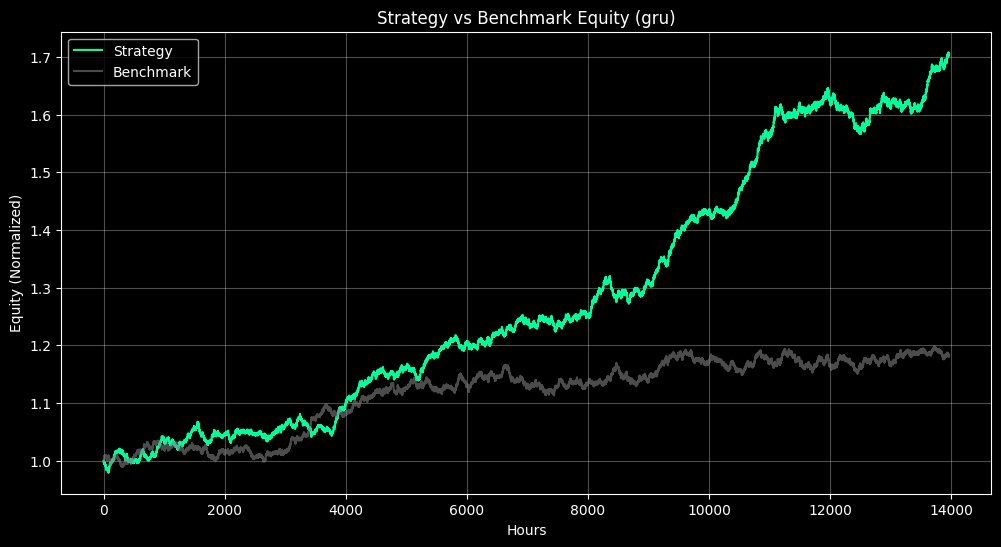

✅ Metadata saved to ../models/gru/btc_gru_hourly_metadata.json
   - Features: 20
   - Seq Len: 24


In [8]:

# ======================
# 8. Backtesting Framework
# ======================
def calculate_metrics(returns):
    # Metrics Calculation Helper
    cumulative = np.cumprod(1 + returns) - 1
    total_ret = cumulative[-1]
    ann_vol = np.std(returns) * np.sqrt(252 * 24)
    sharpe = (np.mean(returns) / np.std(returns)) * np.sqrt(252 * 24) if np.std(returns) > 0 else 0
    
    # Drawdown
    equity = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(equity)
    drawdown = (equity - running_max) / running_max
    max_dd = np.min(drawdown)
    return total_ret, ann_vol, sharpe, max_dd, equity

def backtest_strategy(y_actual, y_pred_proba):
    # Signals: >0.5 Buy, <=0.5 Sell/Short
    signals = np.where(y_pred_proba.flatten() > 0.5, 1, -1)
    
    # Synthetic Market Returns: +0.1% for Up, -0.1% for Down
    market_returns = y_actual * 0.001 + (1 - y_actual) * (-0.001)
    strategy_returns = signals * market_returns
    
    # Calculate Metrics
    strat_ret, strat_vol, strat_sharpe, strat_dd, strat_equity = calculate_metrics(strategy_returns)
    bench_ret, bench_vol, bench_sharpe, bench_dd, bench_equity = calculate_metrics(market_returns)
    
    # Print Table
    print(f"--- Strategy Performance Comparison ---")
    print(f"{'Metric':>15} {'Strategy':>10} {'Benchmark':>10}")
    print(f"{'Total Return':>15} {strat_ret:>9.1%} {bench_ret:>9.1%}")
    print(f"{'Ann. Volatility':>15} {strat_vol:>9.1%} {bench_vol:>9.1%}")
    print(f"{'Sharpe Ratio':>15} {strat_sharpe:>9.2f} {bench_sharpe:>9.2f}")
    print(f"{'Max Drawdown':>15} {strat_dd:>9.1%} {bench_dd:>9.1%}")
    
    return {
        'total_return': strat_ret,
        'annual_volatility': strat_vol,
        'sharpe_ratio': strat_sharpe,
        'max_drawdown': strat_dd,
        'equity_curve': strat_equity,
        'benchmark_equity': bench_equity
    }

results = backtest_strategy(y_test_seq, y_pred_proba)

# Equity Plot
plt.figure(figsize=(12, 6))
plt.plot(results['equity_curve'], label='Strategy', color=COLORS[1])
plt.plot(results['benchmark_equity'], label='Benchmark', color='gray', alpha=0.6)
plt.title(f'Strategy vs Benchmark Equity ({MODEL_NAME})')
plt.xlabel('Hours')
plt.ylabel('Equity (Normalized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 💾 SAVE METADATA FOR DASHBOARD
# ==========================================
import json
import datetime

# Create metadata dictionary
metadata = {
    "model_name": MODEL_NAME,
    "model_type": "Deep Learning",
    "frequency": "1h",
    "target_asset": "BTC/USDT",
    "Architecture": {
        "layers": [layer.name for layer in model.layers],
        "trainable_parameters": int(sum([tf.size(w).numpy() for w in model.trainable_weights]))
    },
    "training_config": {
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "loss_function": "binary_crossentropy",
        "batch_size": 64,
        "max_epochs": 50,
        "early_stopping_patience": 10
    },
    "performance_metrics": {
        "test_accuracy": float(acc),
        "test_auc_roc": float(auc),
        "test_precision": float(prec),
        "test_recall": float(rec),
        "test_f1_score": float(f1)
    },
    "backtesting": {
        "total_return": float(results['total_return']),
        "annual_volatility": float(results['annual_volatility']),
        "sharpe_ratio": float(results['sharpe_ratio']),
        "maximum_drawdown": float(results['max_drawdown'])
    },
    "data_info": {
        "total_samples": len(df),
        "training_samples": len(X_train_seq),
        "test_samples": len(X_test_seq),
        "sequence_length": int(WINDOW_SIZE),
        "feature_selection": "SelectKBest (k=20)"
    },
    "export_timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Save metadata
with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to {METADATA_SAVE_PATH}")
print(f"   - Features: {len(top_features)}")
print(f"   - Seq Len: {WINDOW_SIZE}")
